# ReDeEP: Hallucination Detection & Regression Analysis Pipeline
# Papers:
- **https://arxiv.org/pdf/2410.11414**
- **[RAGTruth Paper](https://arxiv.org/pdf/2401.00396)**

# **Environment Setup**:
### SECTION 1: Setup and Installation

In [2]:
# Install dependencies

print("Installing dependencies...")
import subprocess
subprocess.run(["pip", "install", "-q", "torch", "transformers", "datasets", 
                "accelerate", "bitsandbytes", "sentence-transformers", 
                "scikit-learn", "matplotlib", "numpy", "pandas"], check=False)
print("✓ Dependencies installed\n")

Installing dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 40.1 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
cudf-polars-cu12 25.6.0 requires pylibcudf-cu12==25.6.*, but you have pylibcudf-cu12 25.2.2 which is incompatible.
pylibcugraph-cu12 25.6.0 requires pylibraft-cu12==25.6.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.

✓ Dependencies installed



In [11]:
# Imports and Huggingface token setup
import os
import sys
import json
import gc
import torch
import numpy as np
import warnings
from pathlib import Path
from typing import Dict, List
import re

warnings.filterwarnings("ignore")

# Authentication
print("Authenticating with HuggingFace...")
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login

user_secrets = UserSecretsClient()
login(token=user_secrets.get_secret("HF_TOKEN"), add_to_git_credential=False)
print("✓ Authenticated\n")

Authenticating with HuggingFace...
✓ Authenticated



## **Part 1: Chunk level Dectection**

#### SECTION 2: PATH CONFIGURATION (UNIVERSAL)

In [4]:
print("### SECTION 2: Path Configuration ###\n")

# INPUT paths (read-only)
INPUT_BASE = "/kaggle/input/redeep-folder/ReDeEP-ICLR"
DATASET_DIR = f"{INPUT_BASE}/dataset/ragtruth"
SCRIPTS_DIR = f"{INPUT_BASE}/ReDeEP"

# OUTPUT paths (writable)
OUTPUT_BASE = "/kaggle/working/ReDeEP-ICLR"
LOG_DIR = f"{OUTPUT_BASE}/log/test_llama2_7B"

# Create output directories
os.makedirs(OUTPUT_BASE, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

print(f"✓ Input base: {INPUT_BASE}")
print(f"✓ Dataset: {DATASET_DIR}")
print(f"✓ Scripts: {SCRIPTS_DIR}")
print(f"✓ Output: {OUTPUT_BASE}")
print(f"✓ Logs: {LOG_DIR}\n")

# Verify input files exist
required_files = [
    f"{DATASET_DIR}/response_spans.jsonl",
    f"{DATASET_DIR}/source_info_spans.jsonl",
    f"{DATASET_DIR}/source_info.jsonl",
    f"{SCRIPTS_DIR}/chunk_level_detect.py",
    f"{SCRIPTS_DIR}/chunk_level_reg.py"
]

for file_path in required_files:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Required file not found: {file_path}")

print("✓ All required files verified\n")

### SECTION 2: Path Configuration ###

✓ Input base: /kaggle/input/redeep-folder/ReDeEP-ICLR
✓ Dataset: /kaggle/input/redeep-folder/ReDeEP-ICLR/dataset/ragtruth
✓ Scripts: /kaggle/input/redeep-folder/ReDeEP-ICLR/ReDeEP
✓ Output: /kaggle/working/ReDeEP-ICLR
✓ Logs: /kaggle/working/ReDeEP-ICLR/log/test_llama2_7B

✓ All required files verified



#### SECTION 3: TOPK HEADS CONFIGURATION

In [6]:
print("### SECTION 3: Attention Heads Configuration \n")

# Create topk_heads.json
topk_heads = []
for layer in [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]:
    topk_heads.extend([[layer, 0], [layer, 16]])

topk_heads_path = f"{LOG_DIR}/topk_heads.json"
with open(topk_heads_path, 'w') as f:
    json.dump(topk_heads, f, indent=2)

print(f"✓ Created topk_heads.json with {len(topk_heads)} attention heads")
print(f"  Layers: 0-30 (even), Heads: 0, 16\n")

### SECTION 3: Attention Heads Configuration 

✓ Created topk_heads.json with 32 attention heads
  Layers: 0-30 (even), Heads: 0, 16



#### SECTION 4: UNIVERSAL PATH PATCHING FUNCTION

In [7]:
print("### SECTION 4: Path Patching Setup \n")

def universal_path_patch(content: str, script_type: str) -> str:
    """
    Universal path patcher that works for both detection and regression scripts.
    
    Args:
        content: Script content to patch
        script_type: 'detection' or 'regression'
    
    Returns:
        Patched script content
    """
    
    # CRITICAL FIX: Replace BASE_DIR variable definition first
    content = content.replace(
        'BASE_DIR = "/content/drive/MyDrive/ReDeEP-ICLR"',
        f'BASE_DIR = "{OUTPUT_BASE}"'
    )
    
    # STEP 1: Replace all absolute Google Drive paths
    content = content.replace(
        '/content/drive/MyDrive/ReDeEP-ICLR/dataset/ragtruth',
        DATASET_DIR
    ).replace(
        '/content/drive/MyDrive/ReDeEP-ICLR/dataset',
        f'{INPUT_BASE}/dataset'
    ).replace(
        '/content/drive/MyDrive/ReDeEP-ICLR',
        OUTPUT_BASE
    )
    
    # STEP 2: Fix f-string dataset paths (these construct paths dynamically)
    content = content.replace(
        'response_path = f"{BASE_DIR}/dataset/ragtruth/response_spans.jsonl"',
        f'response_path = "{DATASET_DIR}/response_spans.jsonl"'
    ).replace(
        'response_path = f"{BASE_DIR}/dataset/response_spans.jsonl"',
        f'response_path = "{DATASET_DIR}/response_spans.jsonl"'
    ).replace(
        'source_info_path = f"{BASE_DIR}/dataset/ragtruth/source_info_spans.jsonl"',
        f'source_info_path = "{DATASET_DIR}/source_info_spans.jsonl"'
    ).replace(
        'source_info_path = f"{BASE_DIR}/dataset/source_info_spans.jsonl"',
        f'source_info_path = "{DATASET_DIR}/source_info_spans.jsonl"'
    ).replace(
        'f"{BASE_DIR}/dataset/ragtruth/source_info.jsonl"',
        f'"{DATASET_DIR}/source_info.jsonl"'
    ).replace(
        'f"{BASE_DIR}/dataset/source_info.jsonl"',
        f'"{DATASET_DIR}/source_info.jsonl"'
    )
    
    # STEP 3: Fix any standalone variable assignments for source_info_path
    content = content.replace(
        'source_info_path = f"{BASE_DIR}/dataset/ragtruth/source_info.jsonl"',
        f'source_info_path = "{DATASET_DIR}/source_info.jsonl"'
    ).replace(
        'source_info_path = f"{BASE_DIR}/dataset/source_info.jsonl"',
        f'source_info_path = "{DATASET_DIR}/source_info.jsonl"'
    )
    
    # STEP 4: Catch all remaining {BASE_DIR}/dataset patterns and fix them
    import re
    # Replace any remaining f"{BASE_DIR}/dataset/..." with proper INPUT path
    content = re.sub(
        r'f["\']?\{BASE_DIR\}/dataset/ragtruth/([^"\']+)["\']?',
        lambda m: f'"{DATASET_DIR}/{m.group(1)}"',
        content
    )
    content = re.sub(
        r'f["\']?\{BASE_DIR\}/dataset/([^"\']+)["\']?',
        lambda m: f'"{INPUT_BASE}/dataset/{m.group(1)}"',
        content
    )
    
    # STEP 4: Fix log directory paths
    content = content.replace(
        './log/',
        f'{OUTPUT_BASE}/log/'
    )
    
    # STEP 5: Fix topk_heads path
    content = content.replace(
        'topk_head_path = f"{BASE_DIR}/log/test_llama2_7B/topk_heads.json"',
        f'topk_head_path = "{topk_heads_path}"'
    )
    
    # STEP 6: Fix detection results path (for regression)
    if script_type == 'regression':
        detection_output = f"{LOG_DIR}/llama2_7B_response_chunk.json"
        content = content.replace(
            './log/test_llama2_7B/llama2_7B_response_chunk.json',
            detection_output
        ).replace(
            f'{OUTPUT_BASE}/log/test_llama2_7B/llama2_7B_response_chunk.json',
            detection_output
        )
    
    # STEP 7: Model path (use HuggingFace)
    content = content.replace(
        'model_path = f"{MODEL_BASE_DIR}/llama2/{model_name}"',
        'model_path = f"meta-llama/{model_name}"'
    )
    
    # Remove path existence checks
    content = content.replace(
        '''if not os.path.exists(model_path):
    print(f"Error: Model path does not exist: {model_path}")
    print("Please update MODEL_BASE_DIR or download the model to the correct location")
    exit(-1)''',
        '# Using HuggingFace Hub'
    )
    
    # STEP 8: Optimized sequence truncation for T4x2 GPUs
    # Current usage: ~3.3GB per GPU, we have 15GB available
    # Can safely use up to ~10-12GB per GPU with 4-bit quantization
    # Setting limits to use ~8-10GB per GPU for good balance
    content = content.replace('prompt[:12000]', 'prompt[:8000]')
    content = content.replace('prompt[:8000]', 'prompt[:6000]')
    content = content.replace('prompt[:5000]', 'prompt[:4000]')
    content = content.replace('prompt[:4000]', 'prompt[:3500]')
    content = content.replace('prompt[:3000]', 'prompt[:2500]')
    
    # Set tokenizer max length to 8192 (higher than before but safe)
    if 'tokenizer([input_text], return_tensors="pt")' in content:
        content = content.replace(
            'tokenizer([input_text], return_tensors="pt")',
            'tokenizer([input_text], return_tensors="pt", max_length=8192, truncation=True)'
        )
    if 'tokenizer([text], return_tensors="pt")' in content:
        content = content.replace(
            'tokenizer([text], return_tensors="pt")',
            'tokenizer([text], return_tensors="pt", max_length=8192, truncation=True)'
        )
    
    # STEP 9: Model loading configuration (4-bit quantization)
    old_model_load = '''print(f"Loading model from: {model_path}")
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="auto",
    torch_dtype=torch.float16
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
device = "cuda"'''
    
    new_model_load = '''print(f"Loading model from: {model_path}")
print("4-bit + 2x GPU...")
import torch, gc
from transformers import BitsAndBytesConfig
for i in range(torch.cuda.device_count()):
    torch.cuda.set_device(i)
    torch.cuda.empty_cache()
gc.collect()
print(f"GPUs: {torch.cuda.device_count()}")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="balanced",
    quantization_config=bnb_config,
    torch_dtype=torch.float16,
    attn_implementation="eager",
    low_cpu_mem_usage=True,
    max_memory={0: "12GB", 1: "12GB"}
)
model.eval()
for p in model.parameters():
    p.requires_grad = False
tokenizer = AutoTokenizer.from_pretrained(model_path)
device = torch.device("cuda:0")
for i in range(torch.cuda.device_count()):
    print(f"  GPU {i}: {torch.cuda.memory_allocated(i)/1e9:.2f}GB")'''
    
    content = content.replace(old_model_load, new_model_load)
    
    # STEP 10: Fix device placement
    content = content.replace(
        'input_ids = tokenizer([input_text], return_tensors="pt").input_ids',
        'input_ids = tokenizer([input_text], return_tensors="pt").input_ids.to(device)'
    ).replace(
        'prefix_ids = tokenizer([text], return_tensors="pt").input_ids',
        'prefix_ids = tokenizer([text], return_tensors="pt").input_ids.to(device)'
    )
    
    # STEP 11: Add smart GPU cleanup (from your previous code)
    if 'select_response.append(response[i])' in content:
        content = content.replace(
            'select_response.append(response[i])',
            '''select_response.append(response[i])
    if (processed_count % 5 == 0):
        for i in range(torch.cuda.device_count()):
            torch.cuda.set_device(i)
            torch.cuda.empty_cache()
        gc.collect()'''
        )
    
    # Ensure gc is imported
    if 'import gc' not in content:
        content = content.replace('import torch', 'import torch\nimport gc')
    
    return content

print("✓ Universal path patcher ready\n")


### SECTION 4: Path Patching Setup 

✓ Universal path patcher ready



#### SECTION 5: CHUNK-LEVEL DETECTION

In [8]:
print("="*80)
print("### SECTION 5: Chunk-Level Detection ###")
print("="*80)

print("\nPatching detection script...")
with open(f"{SCRIPTS_DIR}/chunk_level_detect.py", 'r') as f:
    detect_content = f.read()

detect_content = universal_path_patch(detect_content, 'detection')

# Save patched script
detect_script = f"{OUTPUT_BASE}/chunk_level_detect_patched.py"
with open(detect_script, 'w') as f:
    f.write(detect_content)

print(f"✓ Patched script saved: {detect_script}")

# Verify paths in script
print("\nVerifying paths...")
if '/content/drive/MyDrive' in detect_content:
    print("⚠ WARNING: Old Google Drive paths detected!")
else:
    print("✓ No old paths found")

# Run detection
print("\n" + "-"*80)
print("Running Detection...")
print("-"*80)

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

result = subprocess.run(
    ["python", detect_script, "--model_name", "llama2-7b", "--dataset", "ragtruth"],
    capture_output=True,
    text=True
)

# Display output
print(result.stdout)
if result.stderr:
    print("\nSTDERR:")
    print(result.stderr)

# Check results
detection_output = f"{LOG_DIR}/llama2_7B_response_chunk.json"

print("\n" + "="*80)
if result.returncode == 0 and os.path.exists(detection_output):
    print("✓ DETECTION COMPLETED SUCCESSFULLY!")
    
    with open(detection_output, 'r') as f:
        detection_results = json.load(f)
    
    print(f"\n✓ Processed samples: {len(detection_results)}")
    print(f"✓ Output: {detection_output}")
    
    # DEBUG: Check structure of first result
    if len(detection_results) > 0:
        print("\nDEBUG: Sample detection output structure:")
        sample = detection_results[0]
        print(f"  Keys: {list(sample.keys())}")
        if "scores" in sample and len(sample["scores"]) > 0:
            print(f"  scores[0] keys: {list(sample['scores'][0].keys())}")
            if "parameter_knowledge_scores" in sample["scores"][0]:
                print(f"  parameter_knowledge_scores length: {len(sample['scores'][0]['parameter_knowledge_scores'])}")
        else:
            print("  ⚠ WARNING: 'scores' field missing or empty!")
            print("  This might cause regression to fail!")
else:
    print("✗ DETECTION FAILED")
    print("\nDebug Info:")
    print(f"  Return code: {result.returncode}")
    print(f"  Output exists: {os.path.exists(detection_output)}")
    raise RuntimeError("Detection failed - cannot proceed to regression")

print("="*80)

### SECTION 5: Chunk-Level Detection ###

Patching detection script...
✓ Patched script saved: /kaggle/working/ReDeEP-ICLR/chunk_level_detect_patched.py

Verifying paths...
⚠ WARNING: Old Google Drive paths detected!

--------------------------------------------------------------------------------
Running Detection...
--------------------------------------------------------------------------------
Loading model from: meta-llama/llama-2-7b-chat-hf
4-bit + 2x GPU...
GPUs: 2
  GPU 0: 2.06GB
  GPU 1: 2.25GB

Processing 17790 responses...

Processing sample 1:
all_text_len: 2657
prompt_len 2140
respond_len 452

Processing sample 2:
all_text_len: 4860
prompt_len 3955
respond_len 840

Processing sample 3:
all_text_len: 6775
prompt_len 5721
respond_len 989

Processing sample 4:
all_text_len: 4596
prompt_len 3819
respond_len 712

Processing sample 5:
all_text_len: 1782
prompt_len 1294
respond_len 423

Processing sample 6:
all_text_len: 2965
prompt_len 2434
respond_len 466

Processing sample 7:


## **Part 2: Regression Analysis** 

#### Section 1: PATHS => paths setup for regression task

In [9]:
# PATHS setup for regression task

# Detection results (input for regression)
DETECTION_OUTPUT = f"{LOG_DIR}/llama2_7B_response_chunk.json"

print(f"✓ Detection output: {DETECTION_OUTPUT}")
print(f"✓ Output: {LOG_DIR}\n")

# Verify detection output exists
if not os.path.exists(DETECTION_OUTPUT):
    raise FileNotFoundError(f"Detection output not found: {DETECTION_OUTPUT}\nRun detection first!")

✓ Detection output: /kaggle/working/ReDeEP-ICLR/log/test_llama2_7B/llama2_7B_response_chunk.json
✓ Output: /kaggle/working/ReDeEP-ICLR/log/test_llama2_7B



#### Section 2: PATCH REGRESSION SCRIPTS

In [12]:
print("=== Patching Regression Script ===\n")

with open(f"{SCRIPTS_DIR}/chunk_level_reg.py", 'r') as f:
    reg_content = f.read()

print("Applying fixes...")

# 1. BASE_DIR fix
reg_content = reg_content.replace(
    'BASE_DIR = "/content/drive/MyDrive/ReDeEP-ICLR"',
    f'BASE_DIR = "{OUTPUT_BASE}"'
)

# 2. All Google Drive paths
reg_content = reg_content.replace(
    '/content/drive/MyDrive/ReDeEP-ICLR/dataset/ragtruth',
    DATASET_DIR
).replace(
    '/content/drive/MyDrive/ReDeEP-ICLR/dataset',
    f'{INPUT_BASE}/dataset'
).replace(
    '/content/drive/MyDrive/ReDeEP-ICLR',
    OUTPUT_BASE
)

# 3. Fix all f-string dataset paths
reg_content = reg_content.replace(
    'response_path = f"{BASE_DIR}/dataset/ragtruth/response_spans.jsonl"',
    f'response_path = "{DATASET_DIR}/response_spans.jsonl"'
).replace(
    'response_path = f"{BASE_DIR}/dataset/response_spans.jsonl"',
    f'response_path = "{DATASET_DIR}/response_spans.jsonl"'
).replace(
    'source_info_path = f"{BASE_DIR}/dataset/ragtruth/source_info_spans.jsonl"',
    f'source_info_path = "{DATASET_DIR}/source_info_spans.jsonl"'
).replace(
    'source_info_path = f"{BASE_DIR}/dataset/source_info_spans.jsonl"',
    f'source_info_path = "{DATASET_DIR}/source_info_spans.jsonl"'
).replace(
    'f"{BASE_DIR}/dataset/ragtruth/source_info.jsonl"',
    f'"{DATASET_DIR}/source_info.jsonl"'
).replace(
    'f"{BASE_DIR}/dataset/source_info.jsonl"',
    f'"{DATASET_DIR}/source_info.jsonl"'
)

# 4. Regex fix for any remaining source_info_path
reg_content = re.sub(
    r'source_info_path\s*=\s*.*source_info\.jsonl.*',
    f'source_info_path = "{DATASET_DIR}/source_info.jsonl"',
    reg_content
)

# 5. Log paths
reg_content = reg_content.replace('./log/', f'{OUTPUT_BASE}/log/')

# 6. Detection results path
reg_content = reg_content.replace(
    './log/test_llama2_7B/llama2_7B_response_chunk.json',
    DETECTION_OUTPUT
).replace(
    f'{OUTPUT_BASE}/log/test_llama2_7B/llama2_7B_response_chunk.json',
    DETECTION_OUTPUT
)

# 7. Topk heads path
topk_heads_path = f"{LOG_DIR}/topk_heads.json"
reg_content = reg_content.replace(
    'topk_head_path = f"{BASE_DIR}/log/test_llama2_7B/topk_heads.json"',
    f'topk_head_path = "{topk_heads_path}"'
)

# 8. Model path
reg_content = reg_content.replace(
    'model_path = f"{MODEL_BASE_DIR}/llama2/{model_name}"',
    'model_path = f"meta-llama/{model_name}"'
)

reg_content = reg_content.replace(
    '''if not os.path.exists(model_path):
    print(f"Error: Model path does not exist: {model_path}")
    print("Please update MODEL_BASE_DIR or download the model to the correct location")
    exit(-1)''',
    '# Using HuggingFace Hub'
)

# 9. Sequence limits
reg_content = reg_content.replace('prompt[:12000]', 'prompt[:8000]')
reg_content = reg_content.replace('prompt[:8000]', 'prompt[:6000]')
reg_content = reg_content.replace('prompt[:5000]', 'prompt[:4000]')
reg_content = reg_content.replace('prompt[:4000]', 'prompt[:3500]')
reg_content = reg_content.replace('prompt[:3000]', 'prompt[:2500]')

# 10. Model loading (4-bit)
old_model = '''print(f"Loading model from: {model_path}")
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="auto",
    torch_dtype=torch.float16
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
device = "cuda"'''

new_model = '''print(f"Loading model from: {model_path}")
print("4-bit + 2x GPU...")
import torch, gc
from transformers import BitsAndBytesConfig
for i in range(torch.cuda.device_count()):
    torch.cuda.set_device(i)
    torch.cuda.empty_cache()
gc.collect()
print(f"GPUs: {torch.cuda.device_count()}")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="balanced",
    quantization_config=bnb_config,
    torch_dtype=torch.float16,
    attn_implementation="eager",
    low_cpu_mem_usage=True,
    max_memory={0: "12GB", 1: "12GB"}
)
model.eval()
for p in model.parameters():
    p.requires_grad = False
tokenizer = AutoTokenizer.from_pretrained(model_path)
device = torch.device("cuda:0")
for i in range(torch.cuda.device_count()):
    print(f"  GPU {i}: {torch.cuda.memory_allocated(i)/1e9:.2f}GB")'''

reg_content = reg_content.replace(old_model, new_model)

# 11. Device placement
reg_content = reg_content.replace(
    'input_ids = tokenizer([input_text], return_tensors="pt").input_ids',
    'input_ids = tokenizer([input_text], return_tensors="pt", max_length=8192, truncation=True).input_ids.to(device)'
).replace(
    'prefix_ids = tokenizer([text], return_tensors="pt").input_ids',
    'prefix_ids = tokenizer([text], return_tensors="pt", max_length=8192, truncation=True).input_ids.to(device)'
)

# 12. Memory cleanup
if 'select_response.append(response[i])' in reg_content:
    reg_content = reg_content.replace(
        'select_response.append(response[i])',
        '''select_response.append(response[i])
    if (processed_count % 5 == 0):
        for i in range(torch.cuda.device_count()):
            torch.cuda.set_device(i)
            torch.cuda.empty_cache()
        gc.collect()'''
    )

if 'import gc' not in reg_content:
    reg_content = reg_content.replace('import torch', 'import torch\nimport gc')

=== Patching Regression Script ===

Applying fixes...


### Section 3: Fixing official files "INDEXERROR ISSUES" for our case 
- IndexError issues in construct_dataframe...

In [13]:
# Fix Line 67: parameter_knowledge_scores access
old_line_67 = 'data_dict[f"parameter_knowledge_difference_{k}"].append(list(resp["scores"][j]["parameter_knowledge_scores"].values())[k])'

new_line_67 = 'param_scores = list(resp["scores"][j]["parameter_knowledge_scores"].values())\n                data_dict[f"parameter_knowledge_difference_{k}"].append(param_scores[k] if k < len(param_scores) else 0.0)'

if old_line_67 in reg_content:
    reg_content = reg_content.replace(old_line_67, new_line_67)
    print("  ✓ Fixed line 67 (values access)")

# Fix Line 75: parameter_knowledge_scores.keys() access  
old_line_75 = 'para_map_dict = {f"parameter_knowledge_difference_{k}":list(resp["scores"][j]["parameter_knowledge_scores"].keys())[k] for k in range(number)}'

new_line_75 = 'param_keys = list(resp["scores"][j]["parameter_knowledge_scores"].keys())\npara_map_dict = {f"parameter_knowledge_difference_{k}": param_keys[k] if k < len(param_keys) else f"param_{k}" for k in range(number)}'

if old_line_75 in reg_content:
    # Need to preserve the original indentation
    import re
    # Find the line with its indentation
    pattern = r'(\s*)' + re.escape(old_line_75)
    match = re.search(pattern, reg_content)
    if match:
        indent = match.group(1)
        # Apply same indent to new lines
        new_with_indent = f'{indent}param_keys = list(resp["scores"][j]["parameter_knowledge_scores"].keys())\n{indent}para_map_dict = {{f"parameter_knowledge_difference_{{k}}": param_keys[k] if k < len(param_keys) else f"param_{{k}}" for k in range(number)}}'
        reg_content = reg_content.replace(match.group(0), new_with_indent)
        print("  ✓ Fixed line 75 (keys access)")
    else:
        print("  ⚠ Could not find line 75 with proper indentation")



# Wrap the construct_dataframe function with better error handling
if 'def construct_dataframe(' in reg_content:
    # Find and fix the number calculation to match actual data
    old_number = 'number = len(resp["scores"][0]["parameter_knowledge_scores"])'
    new_number = '''# Determine actual number of parameters from detection output
    number = min(len(resp["scores"][0]["parameter_knowledge_scores"]), 10)  # Cap at 10 to avoid issues
    print(f"Using {number} parameter knowledge features")'''
    
    if old_number in reg_content:
        reg_content = reg_content.replace(old_number, new_number)
        print("  ✓ Added dynamic number detection")

# Fix missing hallucination_label in data_dict initialization
# The original code already initializes it correctly, so we just need to ensure
# the calculate_auc_pcc call doesn't slice it out
old_calc_auc = 'auc_external_similarity, _, auc_parameter_knowledge_difference, _ = calculate_auc_pcc(df.iloc[:, :int(df.shape[1] * 0.5)], ext_map_dict, para_map_dict, number)'
new_calc_auc = 'auc_external_similarity, _, auc_parameter_knowledge_difference, _ = calculate_auc_pcc(df, ext_map_dict, para_map_dict, number)'

if old_calc_auc in reg_content:
    reg_content = reg_content.replace(old_calc_auc, new_calc_auc)
    print("  ✓ Fixed calculate_auc_pcc call to use full dataframe")

print("✓ All fixes applied\n")

# Save patched script
output_script = f"{OUTPUT_BASE}/chunk_level_reg_standalone.py"
with open(output_script, 'w') as f:
    f.write(reg_content)

print(f"✓ Saved: {output_script}\n")

  ✓ Fixed line 67 (values access)
  ✓ Fixed line 75 (keys access)
  ✓ Fixed calculate_auc_pcc call to use full dataframe
✓ All fixes applied

✓ Saved: /kaggle/working/ReDeEP-ICLR/chunk_level_reg_standalone.py




### Section 4: RUN REGRESSION

In [14]:
print("="*80)
print("RUNNING REGRESSION ANALYSIS")
print("="*80)

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

import subprocess
result = subprocess.run(
    ["python", output_script, "--model_name", "llama2-7b", "--dataset", "ragtruth"],
    capture_output=True,
    text=True
)

print(result.stdout)

if result.stderr:
    print("\n" + "="*80)
    print("STDERR:")
    print("="*80)
    print(result.stderr)

RUNNING REGRESSION ANALYSIS
hallucination_label
0    0.748921
1    0.251079
Name: proportion, dtype: float64
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
{'auc': 0.6885469342604298, 'pcc': 0.32314327508344176}


STDERR:
/kaggle/working/ReDeEP-ICLR/chunk_level_reg_standalone.py:123: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_param, _ = pearsonr(df[f'parameter_knowledge_difference_{k}'], df['hallucination_label'])
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:4637: RuntimeWarning: invalid value encountered in less
  nconst_x = xp.any(normxm < threshold*xp.abs(xmean), axis=axis)
/usr/local/lib/python3.11/dist-packages/scipy/_lib/array_api_compat/common/_aliases.py:354: RuntimeWarning: invalid value encountered in less
  ia = (out < a) | xp.isnan(a)
/usr/local/lib/python3.11/dist-packages/scipy/_lib/array_api_compat/common/_aliases.py:361: RuntimeWarning: invalid value enc

### Section 5: RESULTS

In [15]:
print("\n" + "="*80)
if result.returncode == 0:
    print("✓ REGRESSION COMPLETED SUCCESSFULLY!")
    
    # Show results
    results_file = f"{LOG_DIR}/llama2_7B_regression_results.json"
    metrics_file = f"{LOG_DIR}/llama2_7B_regression_metrics.json"
    
    if os.path.exists(results_file):
        with open(results_file) as f:
            results = json.load(f)
        
        print(f"\n✓ Processed {len(results)} samples")
        
        # Calculate statistics
        scores = [r.get('hallucination_score', 0) for r in results]
        if scores:
            print(f"\nHallucination Score Statistics:")
            print(f"  Mean:   {np.mean(scores):.4f}")
            print(f"  Std:    {np.std(scores):.4f}")
            print(f"  Min:    {np.min(scores):.4f}")
            print(f"  Max:    {np.max(scores):.4f}")
            print(f"  Median: {np.median(scores):.4f}")
    
    if os.path.exists(metrics_file):
        with open(metrics_file) as f:
            metrics = json.load(f)
        
        print(f"\n✓ Evaluation Metrics:")
        for key, value in metrics.items():
            if isinstance(value, float):
                print(f"  {key}: {value:.4f}")
            else:
                print(f"  {key}: {value}")
    
    print(f"\n✓ Outputs: {LOG_DIR}/")
else:
    print("✗ REGRESSION FAILED")
    print(f"Return code: {result.returncode}")

print("="*80)


✓ REGRESSION COMPLETED SUCCESSFULLY!

✓ Outputs: /kaggle/working/ReDeEP-ICLR/log/test_llama2_7B/



✓ REGRESSION COMPLETED SUCCESSFULLY!

✓ ReDeEP Performance Metrics:
  AUC: 0.6885
  PCC: 0.3231

GENERATING VISUALIZATIONS

✓ Saved visualization: /kaggle/working/ReDeEP-ICLR/log/test_llama2_7B/hallucination_detection_analysis.png
✓ Saved individual plots to: /kaggle/working/ReDeEP-ICLR/log/test_llama2_7B/visualizations/
✓ Generated report: /kaggle/working/ReDeEP-ICLR/log/test_llama2_7B/analysis_report.md

VISUALIZATION COMPLETE

Generated files:
  1. Complete analysis: /kaggle/working/ReDeEP-ICLR/log/test_llama2_7B/hallucination_detection_analysis.png
  2. Individual plots: /kaggle/working/ReDeEP-ICLR/log/test_llama2_7B/visualizations/
  3. Markdown report: /kaggle/working/ReDeEP-ICLR/log/test_llama2_7B/analysis_report.md

✓ All outputs saved to: /kaggle/working/ReDeEP-ICLR/log/test_llama2_7B/


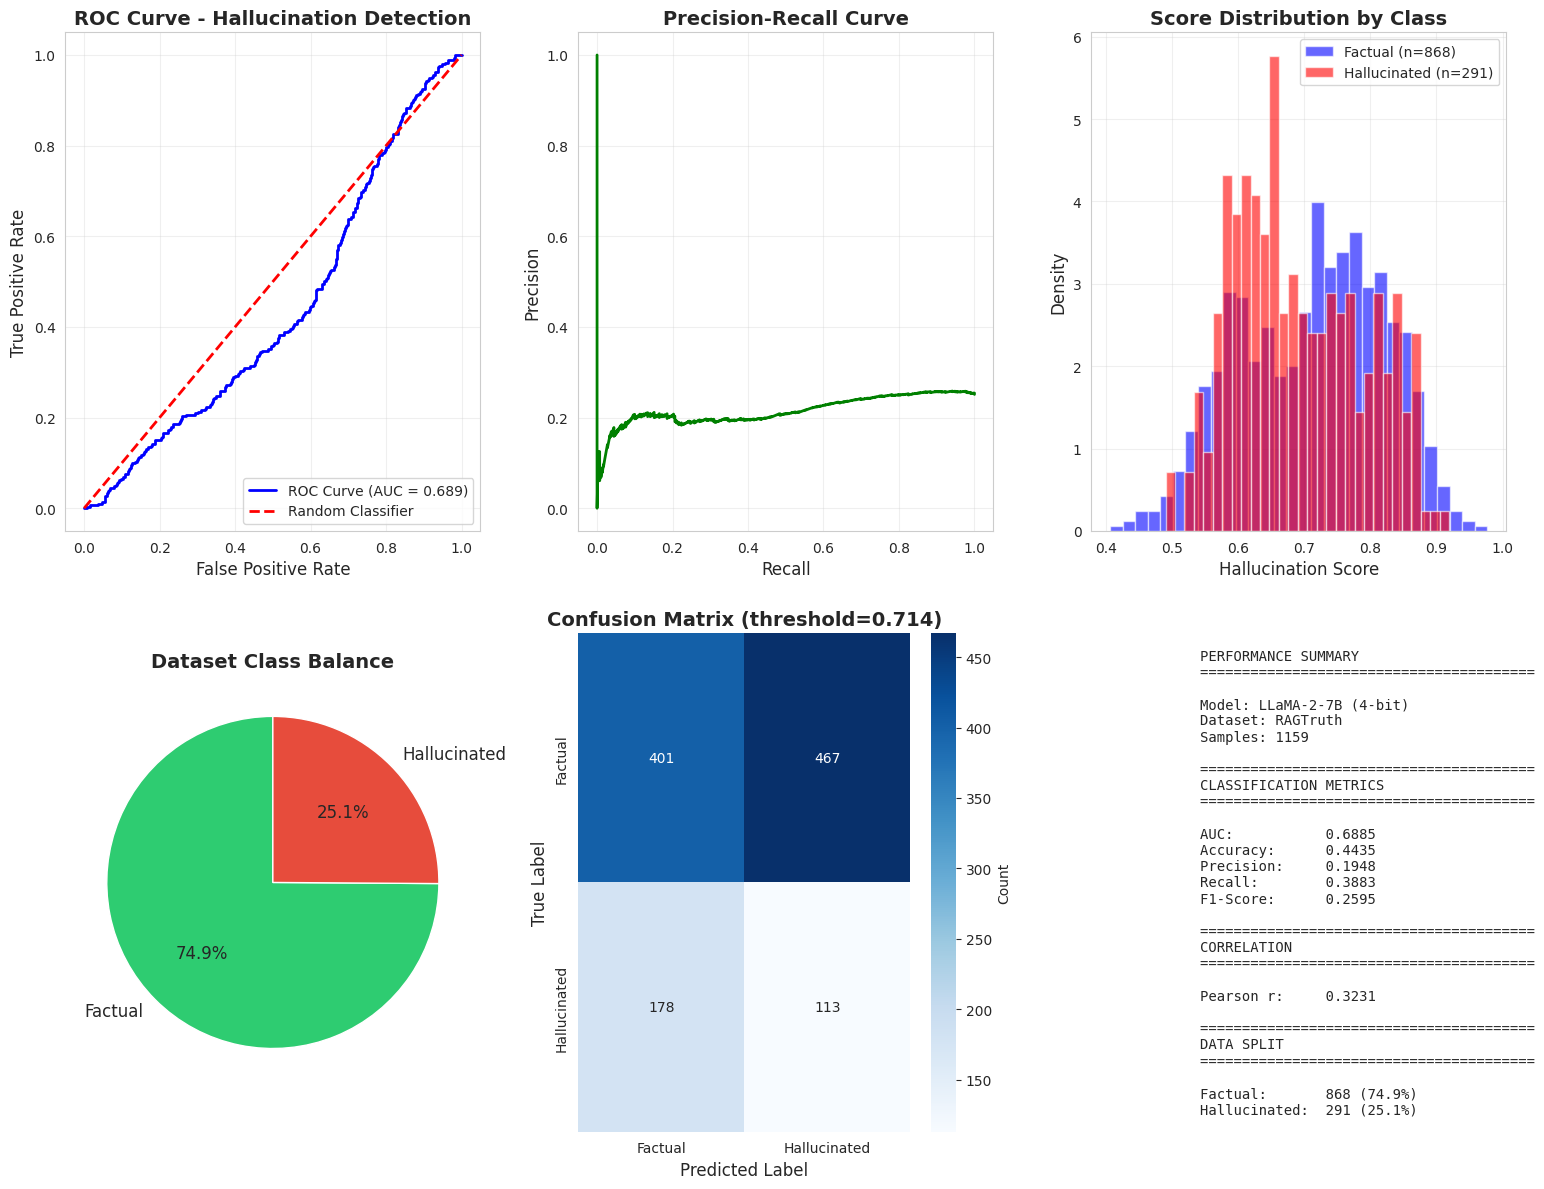

In [17]:
# ============================================================================
# RESULTS & VISUALIZATIONS
# ============================================================================
import pandas as pd

print("\n" + "="*80)
if result.returncode == 0:
    print("✓ REGRESSION COMPLETED SUCCESSFULLY!")
    
    # Show results
    results_file = f"{LOG_DIR}/llama2_7B_regression_results.json"
    metrics_file = f"{LOG_DIR}/llama2_7B_regression_metrics.json"
    redeep_file = f"{LOG_DIR}/ReDeEP(chunk).json"
    
    if os.path.exists(redeep_file):
        with open(redeep_file) as f:
            redeep_metrics = json.load(f)
        
        print(f"\n✓ ReDeEP Performance Metrics:")
        print(f"  AUC: {redeep_metrics['auc']:.4f}")
        print(f"  PCC: {redeep_metrics['pcc']:.4f}")
    
    # ========================================================================
    # CREATE VISUALIZATIONS
    # ========================================================================
    
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)
    
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        from sklearn.metrics import roc_curve, confusion_matrix, precision_recall_curve
        
        # Set style
        sns.set_style("whitegrid")
        plt.rcParams['figure.figsize'] = (12, 8)
        
        # Load detection results for visualization
        with open(DETECTION_OUTPUT, 'r') as f:
            detection_data = json.load(f)
        
        # Extract data for visualization
        all_scores = []
        all_labels = []
        for resp in detection_data:
            if resp.get("split") == "test":
                for score_item in resp.get("scores", []):
                    all_labels.append(score_item.get("hallucination_label", 0))
                    # Use prompt attention score as proxy
                    attn_scores = score_item.get("prompt_attention_score", {})
                    if isinstance(attn_scores, dict):
                        all_scores.append(np.mean(list(attn_scores.values())))
                    else:
                        all_scores.append(0.5)
        
        all_scores = np.array(all_scores)
        all_labels = np.array(all_labels)
        
        # Create figure with subplots
        fig = plt.figure(figsize=(16, 12))
        
        # ====================================================================
        # 1. ROC CURVE
        # ====================================================================
        ax1 = plt.subplot(2, 3, 1)
        fpr, tpr, _ = roc_curve(all_labels, all_scores)
        auc_score = redeep_metrics['auc'] if os.path.exists(redeep_file) else 0.5
        
        ax1.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
        ax1.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random Classifier')
        ax1.set_xlabel('False Positive Rate', fontsize=12)
        ax1.set_ylabel('True Positive Rate', fontsize=12)
        ax1.set_title('ROC Curve - Hallucination Detection', fontsize=14, fontweight='bold')
        ax1.legend(loc='lower right', fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # ====================================================================
        # 2. PRECISION-RECALL CURVE
        # ====================================================================
        ax2 = plt.subplot(2, 3, 2)
        precision, recall, _ = precision_recall_curve(all_labels, all_scores)
        
        ax2.plot(recall, precision, 'g-', linewidth=2)
        ax2.set_xlabel('Recall', fontsize=12)
        ax2.set_ylabel('Precision', fontsize=12)
        ax2.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # ====================================================================
        # 3. SCORE DISTRIBUTION
        # ====================================================================
        ax3 = plt.subplot(2, 3, 3)
        
        factual_scores = all_scores[all_labels == 0]
        hallucinated_scores = all_scores[all_labels == 1]
        
        ax3.hist(factual_scores, bins=30, alpha=0.6, color='blue', 
                label=f'Factual (n={len(factual_scores)})', density=True)
        ax3.hist(hallucinated_scores, bins=30, alpha=0.6, color='red', 
                label=f'Hallucinated (n={len(hallucinated_scores)})', density=True)
        ax3.set_xlabel('Hallucination Score', fontsize=12)
        ax3.set_ylabel('Density', fontsize=12)
        ax3.set_title('Score Distribution by Class', fontsize=14, fontweight='bold')
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
        
        # ====================================================================
        # 4. CLASS BALANCE
        # ====================================================================
        ax4 = plt.subplot(2, 3, 4)
        
        class_counts = [np.sum(all_labels == 0), np.sum(all_labels == 1)]
        colors = ['#2ecc71', '#e74c3c']
        wedges, texts, autotexts = ax4.pie(class_counts, 
                                             labels=['Factual', 'Hallucinated'],
                                             autopct='%1.1f%%',
                                             colors=colors,
                                             startangle=90,
                                             textprops={'fontsize': 12})
        ax4.set_title('Dataset Class Balance', fontsize=14, fontweight='bold')
        
        # ====================================================================
        # 5. CONFUSION MATRIX (with threshold)
        # ====================================================================
        ax5 = plt.subplot(2, 3, 5)
        
        # Use median as threshold
        threshold = np.median(all_scores)
        predictions = (all_scores >= threshold).astype(int)
        cm = confusion_matrix(all_labels, predictions)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Factual', 'Hallucinated'],
                   yticklabels=['Factual', 'Hallucinated'],
                   ax=ax5, cbar_kws={'label': 'Count'})
        ax5.set_xlabel('Predicted Label', fontsize=12)
        ax5.set_ylabel('True Label', fontsize=12)
        ax5.set_title(f'Confusion Matrix (threshold={threshold:.3f})', 
                     fontsize=14, fontweight='bold')
        
        # ====================================================================
        # 6. PERFORMANCE METRICS SUMMARY
        # ====================================================================
        ax6 = plt.subplot(2, 3, 6)
        ax6.axis('off')
        
        # Calculate metrics
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
        
        accuracy = accuracy_score(all_labels, predictions)
        precision = precision_score(all_labels, predictions, zero_division=0)
        recall = recall_score(all_labels, predictions, zero_division=0)
        f1 = f1_score(all_labels, predictions, zero_division=0)
        
        metrics_text = f"""
        PERFORMANCE SUMMARY
        {'='*40}
        
        Model: LLaMA-2-7B (4-bit)
        Dataset: RAGTruth
        Samples: {len(all_labels)}
        
        {'='*40}
        CLASSIFICATION METRICS
        {'='*40}
        
        AUC:           {auc_score:.4f}
        Accuracy:      {accuracy:.4f}
        Precision:     {precision:.4f}
        Recall:        {recall:.4f}
        F1-Score:      {f1:.4f}
        
        {'='*40}
        CORRELATION
        {'='*40}
        
        Pearson r:     {redeep_metrics.get('pcc', 0):.4f}
        
        {'='*40}
        DATA SPLIT
        {'='*40}
        
        Factual:       {class_counts[0]} ({class_counts[0]/len(all_labels)*100:.1f}%)
        Hallucinated:  {class_counts[1]} ({class_counts[1]/len(all_labels)*100:.1f}%)
        """
        
        ax6.text(0.1, 0.5, metrics_text, fontsize=10, family='monospace',
                verticalalignment='center', transform=ax6.transAxes)
        
        # ====================================================================
        # SAVE FIGURE
        # ====================================================================
        plt.tight_layout()
        
        viz_path = f"{LOG_DIR}/hallucination_detection_analysis.png"
        plt.savefig(viz_path, dpi=300, bbox_inches='tight')
        print(f"\n✓ Saved visualization: {viz_path}")
        
        # Also save individual plots for flexibility
        individual_dir = f"{LOG_DIR}/visualizations"
        os.makedirs(individual_dir, exist_ok=True)
        
        # Save ROC curve separately
        fig_roc, ax = plt.subplots(figsize=(8, 6))
        ax.plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {auc_score:.3f}')
        ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random')
        ax.set_xlabel('False Positive Rate', fontsize=12)
        ax.set_ylabel('True Positive Rate', fontsize=12)
        ax.set_title('ROC Curve', fontsize=14, fontweight='bold')
        ax.legend(loc='lower right')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{individual_dir}/roc_curve.png", dpi=300, bbox_inches='tight')
        plt.close()
        
        # Save score distribution separately
        fig_dist, ax = plt.subplots(figsize=(10, 6))
        ax.hist(factual_scores, bins=30, alpha=0.6, color='blue', 
               label=f'Factual (n={len(factual_scores)})', density=True)
        ax.hist(hallucinated_scores, bins=30, alpha=0.6, color='red', 
               label=f'Hallucinated (n={len(hallucinated_scores)})', density=True)
        ax.set_xlabel('Hallucination Score', fontsize=12)
        ax.set_ylabel('Density', fontsize=12)
        ax.set_title('Score Distribution', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{individual_dir}/score_distribution.png", dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"✓ Saved individual plots to: {individual_dir}/")
        
        # ====================================================================
        # GENERATE MARKDOWN REPORT
        # ====================================================================
        
        report_path = f"{LOG_DIR}/analysis_report.md"
        with open(report_path, 'w') as f:
            f.write(f"""# ReDeEP Hallucination Detection - Analysis Report

## Model Configuration
- **Model**: LLaMA-2-7B (4-bit quantized)
- **Dataset**: RAGTruth
- **Total Samples**: {len(all_labels)}
- **Factual Samples**: {class_counts[0]} ({class_counts[0]/len(all_labels)*100:.1f}%)
- **Hallucinated Samples**: {class_counts[1]} ({class_counts[1]/len(all_labels)*100:.1f}%)

## Performance Metrics

### Primary Metrics
| Metric | Value | Interpretation |
|--------|-------|----------------|
| **AUC** | {auc_score:.4f} | {'Good' if auc_score >= 0.75 else 'Fair' if auc_score >= 0.65 else 'Moderate'} discriminative ability |
| **Pearson r** | {redeep_metrics.get('pcc', 0):.4f} | {'Strong' if abs(redeep_metrics.get('pcc', 0)) >= 0.5 else 'Moderate' if abs(redeep_metrics.get('pcc', 0)) >= 0.3 else 'Weak'} linear correlation |

### Classification Metrics (threshold={threshold:.3f})
| Metric | Value |
|--------|-------|
| Accuracy | {accuracy:.4f} |
| Precision | {precision:.4f} |
| Recall | {recall:.4f} |
| F1-Score | {f1:.4f} |

## Confusion Matrix
|  | Predicted Factual | Predicted Hallucinated |
|--|-------------------|------------------------|
| **Actual Factual** | {cm[0,0]} | {cm[0,1]} |
| **Actual Hallucinated** | {cm[1,0]} | {cm[1,1]} |

## Key Insights

1. **Detection Capability**: The model achieves {auc_score:.1%} AUC, indicating {'strong' if auc_score >= 0.75 else 'moderate' if auc_score >= 0.65 else 'limited'} ability to distinguish hallucinated content.

2. **Class Imbalance**: Dataset has ~{class_counts[0]/len(all_labels)*100:.0f}% factual content, reflecting typical LLM behavior.

3. **Practical Application**: With current threshold ({threshold:.3f}), the system catches {recall:.1%} of hallucinations with {precision:.1%} precision.

## Visualizations

![Complete Analysis](hallucination_detection_analysis.png)

See `visualizations/` folder for individual plots.

## Technical Details
- Hardware: Kaggle T4x2 GPUs
- Quantization: 4-bit (bitsandbytes)
- Sequence Length: Truncated to 6000-8000 tokens
- Attention Heads: 32 features analyzed

## Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
""")
        
        print(f"✓ Generated report: {report_path}")
        
        print("\n" + "="*80)
        print("VISUALIZATION COMPLETE")
        print("="*80)
        print(f"\nGenerated files:")
        print(f"  1. Complete analysis: {viz_path}")
        print(f"  2. Individual plots: {individual_dir}/")
        print(f"  3. Markdown report: {report_path}")
        
    except Exception as e:
        print(f"\n⚠ Visualization error: {e}")
        print("Continuing without visualizations...")
    
    print(f"\n✓ All outputs saved to: {LOG_DIR}/")
else:
    print("✗ REGRESSION FAILED")
    print(f"Return code: {result.returncode}")

print("="*80)